# <span style="color:blue">Tomada de Decisão Estratégica sobre Volumes Massivos de Dados</span>

## <span style="color:blue">Notebook com Consultas Analíticas</span>

**Profa. Dra. Cristina Dutra de Aguiar**

**ICMC/USP**

**IMPORTANTE: O uso do *framework* Spark requer diversas configurações no ambiente de desenvolvimento para executar o *notebook*. Dado que tal complexidade foge do escopo de nosso curso, recomenda-se que o *notebook* seja executado na plataforma de desenvolvimento COLAB. O uso do COLAB  proporciona um ambiente de desenvolvimento pré-configurado e remove a complexidade de instalação e configuração de pacotes e *frameworks* que são utilizados no curso.** 


# 1 Projeto do data mart Pagamento

**Tabelas de dimensão**

data (dataPK, dataCompleta, dataDia, dataMes, dataBimestre, dataTrimestre, dataSemestre, dataAno)

funcionario (funcPK, funcMatricula, funcNome, funcSexo, funcDataNascimento, funcDiaNascimento, funcMesNascimento, funcAnoNascimento, funcCidade, funcEstadoNome, funcEstadoSigla, funcRegiaoNome, funcRegiaoSigla, funcPaisNome, funcPaisSigla)

equipe (equipePK, equipeNome, filialNome, filialCidade, filialEstadoNome, filialEstadoSigla, filialRegiaoNome, filialRegiaoSigla, filialPaisNome, filialPaisSigla)

cargo (cargoPK, cargoNome, cargoRegimeTrabalho, cargoEscolaridadeMinima, cargoNivel)

**Tabela de fatos**

pagamento (dataPK, funcPK, equipePK, cargoPK, salario, quantidadeLancamentos)

# 2. Obtenção dos Dados

## 2.1 Instalando o módulo wget

Para obter os dados referentes ao projeto do data mart Pagamento, é utilizado o módulo  **wget**. A instalação desse módulo é feita a seguir. <br>

In [ ]:
# instalando o módulo wget
%%capture
!pip install -q wget

# criando uma pasta para salvar os dados das relações
!mkdir data

# importando o módulo wget
import wget

## 2.2 Obtendo os dados que povoam as tabelas de dimensão

In [ ]:
# obtendo os dados da tabela de dimensão data
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/data.csv"
wget.download(url, "data/data.csv")

# obtendo os dados da tabela de dimensão funcionario
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/funcionario.csv"
wget.download(url, "data/funcionario.csv")

# obtendo os dados da tabela de dimensão equipe
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/equipe.csv"
wget.download(url, "data/equipe.csv")

# obtendo os dados da tabela de dimensão cargo
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/cargo.csv"
wget.download(url, "data/cargo.csv")


'data/cargo (1).csv'

## 2.3 Obtendo os dados que povoam a tabela de fatos

In [ ]:
# obtendo os dados da tabela de fatos pagamento
url = "https://raw.githubusercontent.com/CristinaAguiar/DataMartCelebCo/main/pagamento.csv"
wget.download(url, "data/pagamento.csv")

'data/pagamento (1).csv'

# 3 Configuração do Apache Spark Cluster

## 3.1 Instalando pacotes

Neste *notebook* é criado um *cluster* Spark composto apenas por um **nó mestre**. Ou seja, o *cluster* não possui um ou mais **nós de trabalho** e o **gerenciador de cluster**. Nessa configuração, as tarefas (*tasks*) são realizadas no próprio *driver* localizado no **nó mestre**.

Para que o cluster possa ser criado, primeiramente é instalado o Java Runtime Environment (JRE) versão 11. 

In [ ]:
# instalando Java Runtime Environment (JRE) versão 11
%%capture
!apt-get remove openjdk*
!apt-get update --fix-missing
!apt-get install openjdk-11-jdk

Na sequência, é feito o *download* do Apache Spark versão 3.2.2.

In [ ]:
# baixando Apache Spark versão 3.2.2
%%capture
!wget -c https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz -O spark-bin-hadoop.tgz
!tar xf spark-bin-hadoop.tgz && rm spark-bin-hadoop.tgz

Na sequência, são configuradas as variáveis de ambiente JAVA_HOME e SPARK_HOME. Isto permite que tanto o Java quanto o Spark possam ser encontrados.

In [ ]:
import os

# configurando a variável de ambiente JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64"

# configurando a variável de ambiente SPARK_HOME
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

Também são instalados dois pacotes da linguagem de programação Python, cujas funcionalidades são descritas a seguir.

> **Pacote findspark:** Usado para ler a variável de ambiente SPARK_HOME e armazenar seu valor na variável dinâmica de ambiente PYTHONPATH. Como resultado, Python pode encontrar a instalação do Spark. 

> **Pacote pyspark:** PySpark é a API do Python para Spark. Ela possibilita o uso de Python, considerando que o *framework* Apache Spark encontra-se desenvolvido na linguagem de programação Scala. 

In [ ]:
%%capture

#instalando o pacote findspark
!pip install -q findspark==2.0.1

#instalando o pacote pyspark
!pip install -q pyspark==3.2.2

PySpark não é adicionado ao *sys.path* por padrão. Isso significa que não é possível importá-lo, pois o interpretador da linguagem Python não sabe onde encontrá-lo. Para resolver esse aspecto, é necessário instalar o módulo `findspark`, o qual mostra onde PySpark está localizado. 


In [ ]:
# importando o módulo findspark
import findspark

# carregando a variávels SPARK_HOME na variável dinâmica PYTHONPATH
findspark.init()

## 3.3 Criando uma sessão

Depois de configurados os pacotes e módulos e inicializadas as variáveis de ambiente, é possível iniciar o uso do Spark. Para tanto, é necessário importar o comando `SparkSession` do módulo `pyspark.sql`. São utilizados os seguintes conceitos: <br>

- `SparkSession`: permite a criação de `DataFrames`. Como resultado, as tabelas relacionais podem ser manipuladas por meio de `DataFrames` e é possível realizar consultas analíticas por meio de comandos SQL. <br>
- `builder`: cria uma instância de SparkSession. <br>
- `appName`: define um nome para a aplicação, o qual pode ser visto na interface de usuário web do Spark. <br> 
- `master`: define onde está o nó mestre do *cluster*. Como a aplicação é executada localmente e não em um *cluster*, indica-se isso pela *string* `local` seguida do parâmetro `[*]`. Ou seja, define-se que apenas núcleos locais são utilizados. 
- `getOrCreate`: cria uma SparkSession. Caso ela já exista, retorna a instância existente. 


**Observação**: A lista completa de todos os parâmetros que podem ser utilizados na inicialização do *cluster* pode ser encontrada neste [link](https://spark.apache.org/docs/latest/spark-standalone.html#cluster-launch-scripts).

In [ ]:
# criando SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("pyspark-notebook").master("local[*]").getOrCreate()

# 4 Carregamento dos Dados


## 4.1 Criando DataFrames em Spark 
Para a leitura dos dados dos arquivos .csv, é utilizado o método `spark.read.csv`. Seus parâmetros são:


- `path`: endereço do arquivo que é lido.
- `header`: indica se o arquivo possui um cabeçalho.
- `sep`: especifica o caractere que separa os campos do arquivo.



### 4.1.1 Criando DataFrames em Spark para as tabelas de dimensão

In [ ]:
# criando e exibindo o DataFrame para a tabela de dimensão data
data = spark.read.csv(path="data/data.csv", header=True, sep=",") 
data.show(5)

+------+------------+-------+-------+------------+-------------+------------+-------+
|dataPK|dataCompleta|dataDia|dataMes|dataBimestre|dataTrimestre|dataSemestre|dataAno|
+------+------------+-------+-------+------------+-------------+------------+-------+
|     1|  01/01/2017|      1|      1|           1|            1|           1|   2017|
|     2|  02/01/2017|      2|      1|           1|            1|           1|   2017|
|     3|  03/01/2017|      3|      1|           1|            1|           1|   2017|
|     4|  04/01/2017|      4|      1|           1|            1|           1|   2017|
|     5|  05/01/2017|      5|      1|           1|            1|           1|   2017|
+------+------------+-------+-------+------------+-------------+------------+-------+
only showing top 5 rows



In [ ]:
# criando e exibindo o DataFrame para a tabela de fatos funcionario
funcionario = spark.read.csv(path="data/funcionario.csv", header=True, sep=",")
funcionario.show(5)

+------+-------------+------------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|          funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento| funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+------------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|     1|          M-1|MARGARET HENDERSON|       F|        01/01/1992|                1|                1|             1992|  SAO PAULO|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|     2|          M-2|       LLOYD UPTON|       M|        02/02/1992|                2|             

In [ ]:
# criando e exibindo o DataFrame para a tabela de dimensão equipe
equipe = spark.read.csv(path="data/equipe.csv", header=True, sep=",")
equipe.show(5)

+--------+-------------+--------------------+--------------+------------------+-----------------+----------------+-----------------+--------------+---------------+
|equipePK|   equipeNome|          filialNome|  filialCidade|  filialEstadoNome|filialEstadoSigla|filialRegiaoNome|filialRegiaoSigla|filialPaisNome|filialPaisSigla|
+--------+-------------+--------------------+--------------+------------------+-----------------+----------------+-----------------+--------------+---------------+
|       1| SERVICO PLUS|SAO PAULO - IPIRANGA|     SAO PAULO|         SAO PAULO|               SP|         SUDESTE|               SE|        BRASIL|             BR|
|       2| SERVICO PLUS|RIO DE JANEIRO - ...|RIO DE JANEIRO|    RIO DE JANEIRO|               RJ|         SUDESTE|               SE|        BRASIL|             BR|
|       3|SERVICO BASIC|SAO PAULO - IPIRANGA|     SAO PAULO|         SAO PAULO|               SP|         SUDESTE|               SE|        BRASIL|             BR|
|       4|SERVIC

In [ ]:
# criando e exibindo o DataFrame para a tabela de dimensão cargo
cargo = spark.read.csv(path="data/cargo.csv", header=True, sep=",")
cargo.show(5)


+-------+----------+-------------------+--------------------+-----------------------+----------+
|cargoPK| cargoNome|cargoRegimeTrabalho|cargoJornadaTrabalho|cargoEscolaridadeMinima|cargoNivel|
+-------+----------+-------------------+--------------------+-----------------------+----------+
|      1|COZINHEIRO|         TEMPORARIO|                 20H|                  MEDIO|    JUNIOR|
|      2|COZINHEIRO|         TEMPORARIO|                 20H|               SUPERIOR|     PLENO|
|      3|COZINHEIRO|         TEMPORARIO|                 20H|                    POS|    SENIOR|
|      4|COZINHEIRO|         TEMPORARIO|                 40H|                  MEDIO|    JUNIOR|
|      5|COZINHEIRO|         TEMPORARIO|                 40H|               SUPERIOR|     PLENO|
+-------+----------+-------------------+--------------------+-----------------------+----------+
only showing top 5 rows



### 4.1.2 Criando DataFrames em Spark para a tabela de fatos

In [ ]:
# criando e exibindo o DataFrame para a tabela de fatos pagamento
pagamento = spark.read.csv(path="data/pagamento.csv", header=True, sep=",")
pagamento.show()

+------+--------+------+-------+--------+---------------------+
|funcPK|equipePK|dataPK|cargoPK| salario|quantidadeLancamentos|
+------+--------+------+-------+--------+---------------------+
|   147|       2|     5|     64| 1299.95|                    1|
|   124|       2|     5|    329| 6752.31|                    1|
|   175|       1|     5|    328| 2110.43|                    1|
|   171|       1|     5|    245| 6568.92|                    1|
|   148|       2|     5|     65| 3670.49|                    1|
|     5|       2|     5|    112| 1855.55|                    1|
|   128|       1|     5|    341| 5130.87|                    1|
|    82|       2|     5|     43| 1321.26|                    1|
|    28|       1|     5|    253| 1328.35|                    1|
|    46|       1|     5|    390| 8233.47|                    1|
|    91|       2|     5|    233| 9109.56|                    1|
|   176|       2|     5|    241| 1671.24|                    1|
|   172|       1|     5|    351|11848.57

## 4.2 Atualização dos Tipos de Dados 

Os dados importados encontram-se no formato string. Torna-se necessário mudar o formato desses dados. 

### 4.2.1 Atualizando os dados que são do tipo inteiro

Primeiramente, são identificados quais colunas de quais DataFrames em Spark devem ser do tipo inteiro. Na sequência, ocorre a atualização dos dados dessas colunas para o tipo inteiro.

In [ ]:
# identificando quais colunas de quais DataFrames devem ser do tipo de dado inteiro
colunas_cargo = ["cargoPK"]
colunas_data = ["dataPK", "dataDia", "dataMes", "dataBimestre", "dataTrimestre", "dataSemestre", "dataAno"]
colunas_equipe = ["equipePK"]
colunas_funcionario = ["funcPK", "funcDiaNascimento", "funcMesNascimento", "funcAnoNascimento"]
colunas_pagamento = ["funcPK", "equipePK", "dataPK", "cargoPK", "quantidadeLancamentos"]

In [ ]:
# importando o tipo de dado desejado
from pyspark.sql.types import IntegerType

# atualizando o tipo de dado das colunas especificadas 
# substituindo as colunas já existentes 

for coluna in colunas_cargo:
  cargo = cargo.withColumn(coluna, cargo[coluna].cast(IntegerType()))

for coluna in colunas_data:
  data = data.withColumn(coluna, data[coluna].cast(IntegerType()))

for coluna in colunas_equipe:
  equipe = equipe.withColumn(coluna, equipe[coluna].cast(IntegerType()))

for coluna in colunas_funcionario:
  funcionario = funcionario.withColumn(coluna, funcionario[coluna].cast(IntegerType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(IntegerType()))

### 4.2.2 Atualizando os dados que são do tipo ponto flutuante

Primeiramente, são identificados quais colunas de quais DataFrames em Spark devem ser do tipo ponto flutuante. Na sequência, ocorre a atualização dos dados dessas colunas para o tipo ponto flutuante.

In [ ]:
# identificando quais colunas de quais DataFrames devem ser do tipo de dado número de ponto flutuante
colunas_pagamento = ["salario"]

In [ ]:
# importando o tipo de dado desejado
from pyspark.sql.types import FloatType


# atualizando o tipo de dado das colunas especificadas 
# substituindo as colunas já existentes 

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(FloatType()))

## 4.3 Criação de Visões Temporárias

Para que seja possível executar consultas SQL usando Spark SQL, é necessário criar visões temporárias. Uma visão temporária é uma forma na qual um DataFrame em Spark pode ser consultado como se fosse uma tabela.

Para tanto, deve ser utilizado o método  `createOrReplaceTempView` e deve ser passado como parâmetro uma *string* que é o nome da tabela que é criada a partir do DataFrame em Spark. 

### 4.3.1 Criando visões temporárias para as tabelas de dimensão

In [ ]:
# criando as visões temporárias para as tabelas de dimensão
cargo.createOrReplaceTempView("cargo")
data.createOrReplaceTempView("data")
equipe.createOrReplaceTempView("equipe")
funcionario.createOrReplaceTempView("funcionario")

### 4.3.2 Criando visões temporárias para a tabela de fatos

In [ ]:
# criando as visões temporárias para as tabelas de fatos
pagamento.createOrReplaceTempView("pagamento")

# 5 Definição de Operações OLAP Típicas

## 5.1 Definindo a operação *slice and dice*

**Definição**: Restringe os dados sendo analisados a um subconjunto desses dados.

- Slice: corte para um valor fixo, diminuindo a dimensionalidade do cubo.
- Dice: seleção de faixas de valores.


## 5.2 Definindo as operações *drill-down* e *roll-up*

**Definição**: Analisam os dados considerando níveis progressivos de agregação.

- Drill-down: níveis de agregação progressivamente mais detalhados, ou de menor granularidade.
- Roll-up: níveis de agregação progressivamente menos detalhados, ou de maior granularidade.

## 5.3 Definindo a operação *pivot*

**Definição:** Reorienta a visão multidimensional dos dados, oferecendo diferentes perspectivas dos mesmos dados.

# 6 Execução de Consultas Analíticas com Foco na Tomada de Decisão Estratégica

As consultas analíticas requisitadas por usuários de sistemas de suporte à decisão usualmente requerem que várias operações OLAP sejam realizadas simultaneamente. Adicionalmente, a resposta obtida em uma consulta pode ser utilizada para novas investigações em uma consulta subsequente.

Além disso, é importante saber durante a especificação de uma consulta analítica que:

- Resultados mais semânticos deve ser exibidos.

- Os dados numéricos de ponto flutuante devem ser arredondados para facilitar a visualização.

- As linhas dos relatórios devem ser exibidas de forma ordenada.

- Pode haver a necessidade de se calcular e exibir valores derivados. 

- As colunas dos relatórios devem possuir nomes semânticos para facilitar o entendimento.

## 6.1 Consulta 1

Qual o total de despesas em salários nos anos de 2017 a 2021 em cada região na qual a equipe está localizada, considerando o cargo de nível junior?  

In [ ]:
query = """
SELECT dataAno AS ANO,
       filialRegiaoNome AS REGIAO,
       ROUND(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK
               JOIN equipe ON equipe.equipePK = pagamento.equipePK
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
WHERE dataAno BETWEEN 2017 AND 2021
      AND cargoNivel = "JUNIOR"
GROUP BY dataAno, filialRegiaoNome
ORDER BY `TOTAL DE DESPESA` DESC, dataAno DESC, filialRegiaoNome
"""

spark.sql(query).show()

+----+------------+----------------+
| ANO|      REGIAO|TOTAL DE DESPESA|
+----+------------+----------------+
|2021|     SUDESTE|      1048173.96|
|2020|     SUDESTE|      1048173.96|
|2019|     SUDESTE|       880174.08|
|2018|     SUDESTE|       730128.84|
|2017|     SUDESTE|       407880.84|
|2021|CENTRO-OESTE|       280894.44|
|2020|CENTRO-OESTE|       280894.44|
|2019|CENTRO-OESTE|       280894.44|
|2021|    NORDESTE|       134026.92|
|2020|    NORDESTE|       134026.92|
|2018|CENTRO-OESTE|       128740.32|
+----+------------+----------------+



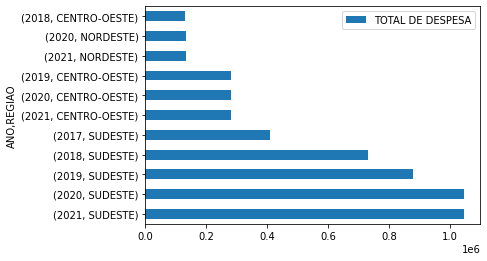

In [ ]:
# transformando o resultado da consulta em Pandas
gastosRegiaoJunior = spark.sql(query).toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
gastosRegiaoJunior.set_index(['ANO', 'REGIAO']).plot(kind = 'barh', stacked=True)

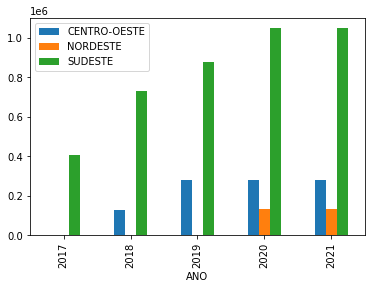

In [ ]:
# visualizando os dados "quebrados" por região
legend = ['CENTRO-OESTE', 'NORDESTE', 'SUDESTE']
ax = gastosRegiaoJunior.set_index(['ANO', 'REGIAO']).unstack().plot(kind = 'bar')
ax.legend(legend); # atualiza os labels

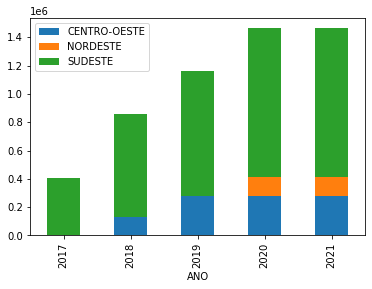

In [ ]:
# visualizando os dados "quebrados" e empilhados por região
legend = ['CENTRO-OESTE', 'NORDESTE', 'SUDESTE']
ax = gastosRegiaoJunior.set_index(['ANO', 'REGIAO']).unstack().plot(kind = 'bar', stacked=True)
ax.legend(legend); # atualiza os labels

## 6.2 Consulta 2

Por meio das respostas da Consulta 1, é possível identificar qual ano e qual região correspondem ao maior gasto em salários. Utilizando essa resposta, mostre qual o total de despesas em cada estado desta região.  

Qual o total de despesas em salários no ano de 2021 em cada estado da região Sudeste, considerando o cargo de nível junior?  

In [ ]:
query = """
SELECT filialEstadoNome AS ESTADO,
       ROUND(SUM(salario), 0) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK
               JOIN equipe ON equipe.equipePK = pagamento.equipePK
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
WHERE dataAno = 2021
      AND cargoNivel = "JUNIOR"
      AND filialRegiaoNome = "SUDESTE"
GROUP BY filialEstadoNome
ORDER BY filialEstadoNome ASC
"""

spark.sql(query).show()

+--------------+----------------+
|        ESTADO|TOTAL DE DESPESA|
+--------------+----------------+
|RIO DE JANEIRO|        384111.0|
|     SAO PAULO|        664063.0|
+--------------+----------------+



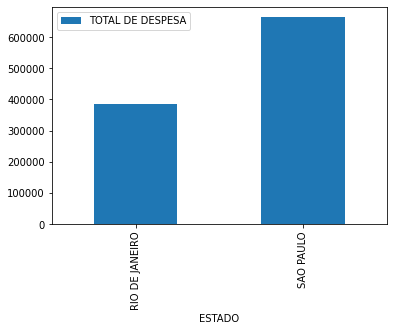

In [ ]:
# transformando o resultado da consulta em Pandas
gastosEstadoSP = spark.sql(query).toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas 
ax = gastosEstadoSP.set_index(['ESTADO']).plot(kind = 'bar')

## 6.3 Consulta 3

Por meio das respostas da Consulta 2, é possível identificar qual estado possui maior gasto em salários. Utilizando essa resposta, mostre qual o total de despesas por sexo para esse estado.  

Qual o total de despesas em salários por sexo para o ano de 2021, o estado de São Paulo da região Sudeste e o cargo de nível junior?

In [ ]:
# FORMAT_NUMBER() retorna uma STRING formatada para facilitar a leitura - não dá para usar nas visualizações .plot()
# ROUND() arredonda o valor e retorna um FLOAT - podemos realizar operações matemáticas sobre este valor
query = """
SELECT funcSexo AS SEXO,
       FORMAT_NUMBER(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK
               JOIN equipe ON equipe.equipePK = pagamento.equipePK
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
WHERE dataAno = 2021
      AND filialRegiaoNome = "SUDESTE"
      AND filialEstadoNome = "SAO PAULO"
      AND cargoNivel = "JUNIOR"
GROUP BY funcSexo
ORDER BY funcSexo ASC
"""

spark.sql(query).show()

+----+----------------+
|SEXO|TOTAL DE DESPESA|
+----+----------------+
|   F|      141,779.64|
|   M|      522,283.56|
+----+----------------+



## 6.4 Consulta 4

Qual a diferença entre os totais de despesas, considerando a Consulta 3? 

Quanto se gasta a mais para pagar os salários dos funcionários de sexo masculino no ano de 2021, estado de São Paulo, região Sudeste e cargo de nível junior?  

In [ ]:
query = """
SELECT FORMAT_NUMBER(salarioF, 2) AS `DESPESAS COM FUNCIONARIAS`,
       FORMAT_NUMBER(salarioM, 2) AS `DESPESAS COM FUNCIONARIOS`,
       FORMAT_NUMBER(salarioM-salarioF, 2) AS `DIFERENCA ENTRE AS DESPESAS`
FROM ( SELECT SUM(salario) AS `Total de Despesa`
       FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
       WHERE dataAno = 2021
         AND filialRegiaoNome = "SUDESTE"
         AND filialEstadoNome = "SAO PAULO"
         AND cargoNivel = "JUNIOR"
         AND funcSexo = "F"  
     ) AS pagF(salarioF), 
     ( SELECT SUM(salario) AS `Total de Despesa`
       FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
       WHERE dataAno = 2021
         AND filialRegiaoNome = "SUDESTE"
         AND filialEstadoNome = "SAO PAULO"
         AND cargoNivel = "JUNIOR"
         AND funcSexo = "M"
      ) AS pagM(salarioM) 
"""

spark.sql(query).show()

+-------------------------+-------------------------+---------------------------+
|DESPESAS COM FUNCIONARIAS|DESPESAS COM FUNCIONARIOS|DIFERENCA ENTRE AS DESPESAS|
+-------------------------+-------------------------+---------------------------+
|               141,779.64|               522,283.56|                 380,503.92|
+-------------------------+-------------------------+---------------------------+



In [ ]:
query = """
SELECT cargoNivelF AS CARGO,
       FORMAT_NUMBER(salarioF, 2) AS `DESPESAS COM FUNCIONARIAS`,
       FORMAT_NUMBER(salarioM, 2) AS `DESPESAS COM FUNCIONARIOS`,
       FORMAT_NUMBER(salarioM-salarioF, 2) AS `DIFERENCA ENTRE AS DESPESAS`
FROM ( SELECT cargoNivel, SUM(salario) AS `Total de Despesa`
       FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
       WHERE dataAno = 2021
         AND filialRegiaoNome = "SUDESTE"
         AND filialEstadoNome = "SAO PAULO"
         AND funcSexo = "F"  
       GROUP BY cargoNivel  
     ) AS pagF(cargoNivelF, salarioF), 
     ( SELECT cargoNivel, SUM(salario) AS `Total de Despesa`
       FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
       WHERE dataAno = 2021
         AND filialRegiaoNome = "SUDESTE"
         AND filialEstadoNome = "SAO PAULO"
         AND funcSexo = "M"
       GROUP BY cargoNivel   
      ) AS pagM(cargoNivelM, salarioM) 
WHERE cargoNivelF = cargoNivelM      
"""

spark.sql(query).show()

+------+-------------------------+-------------------------+---------------------------+
| CARGO|DESPESAS COM FUNCIONARIAS|DESPESAS COM FUNCIONARIOS|DIFERENCA ENTRE AS DESPESAS|
+------+-------------------------+-------------------------+---------------------------+
|JUNIOR|               141,779.64|               522,283.56|                 380,503.92|
| PLENO|               654,855.98|             1,436,093.29|                 781,237.31|
|SENIOR|             1,185,184.56|             2,497,996.55|               1,312,811.98|
+------+-------------------------+-------------------------+---------------------------+



# 7 Extensões ROLLUP, CUBE e GROUPING SETS 

**Definição:** Constroem vários níveis de agregação.

- ROLLUP: criação de subtotais para as combinações dos atributos da lista de agrupamento de acordo com a ordem desses atributos. São criados n+1 níveis de agregação, sendo n o número de atributos especificados na lista de agrupamento.

- CUBE: criação de subtotais para todas as combinações dos atributos da lista de agrupamento. São criados 2ˆn (2 elevado a n) níveis, sendo n o número de atributos especificados na lista de agrupamento.

- GROUPING SETS: criação de subtotais para quaisquer combinações de atributos de agrupamentos. É criada a quantidade de subtotais especificados na lista de níveis de agregação desejados. 


## 7.1 Exemplo de consulta com ROLLUP e GROUPING SETS


Liste as agregações que podem ser geradas a partir do total de despesas em salários por sexo por nível de cargo para o ano de 2021 e o estado de São Paulo da região Sudeste. Crie subtotais considerando a ordem dos atributos na lista de agrupamento.

In [ ]:
# Lembre-se não conseguimos ordernar as colunas pelo `TOTAL DE DESPESA` se utilizarmos o FORMAT_NUMBER
# mas podemos ordernas as colunas pelo SUM(salario), assim ORDER BY SUM(salario) DESC
query = """
SELECT funcSexo,
       cargoNivel, 
       FORMAT_NUMBER(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
WHERE dataAno = 2021
      AND filialRegiaoNome = "SUDESTE"
      AND filialEstadoNome = "SAO PAULO"
GROUP BY ROLLUP(funcSexo, cargoNivel)
ORDER BY cargoNivel DESC, funcSexo DESC
"""

spark.sql(query).show()

+--------+----------+----------------+
|funcSexo|cargoNivel|TOTAL DE DESPESA|
+--------+----------+----------------+
|       M|    SENIOR|    2,497,996.55|
|       F|    SENIOR|    1,185,184.56|
|       M|     PLENO|    1,436,093.29|
|       F|     PLENO|      654,855.98|
|       M|    JUNIOR|      522,283.56|
|       F|    JUNIOR|      141,779.64|
|       M|      null|    4,456,373.39|
|       F|      null|    1,981,820.18|
|    null|      null|    6,438,193.57|
+--------+----------+----------------+



In [ ]:
query = """
SELECT funcSexo,
       cargoNivel,
       FORMAT_NUMBER(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
WHERE dataAno = 2021
      AND filialRegiaoNome = "SUDESTE"
      AND filialEstadoNome = "SAO PAULO"
GROUP BY GROUPING SETS((funcSexo, cargoNivel), (funcSexo), ())
ORDER BY cargoNivel DESC, funcSexo DESC
"""

spark.sql(query).show()

+--------+----------+----------------+
|funcSexo|cargoNivel|TOTAL DE DESPESA|
+--------+----------+----------------+
|       M|    SENIOR|    2,497,996.55|
|       F|    SENIOR|    1,185,184.56|
|       M|     PLENO|    1,436,093.29|
|       F|     PLENO|      654,855.98|
|       M|    JUNIOR|      522,283.56|
|       F|    JUNIOR|      141,779.64|
|       M|      null|    4,456,373.39|
|       F|      null|    1,981,820.18|
|    null|      null|    6,438,193.57|
+--------+----------+----------------+



## 7.2 Exemplo de consulta com CUBE e GROUPING SETS

Liste todas as agregações que podem ser geradas a partir do total de despesas em salários por sexo por nível de cargo para o ano de 2021 e o estado de São Paulo da região Sudeste.

In [ ]:
query = """
SELECT funcSexo,
       cargoNivel,
       FORMAT_NUMBER(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
WHERE dataAno = 2021
      AND filialRegiaoNome = "SUDESTE"
      AND filialEstadoNome = "SAO PAULO"
GROUP BY CUBE(funcSexo, cargoNivel)
ORDER BY cargoNivel DESC, funcSexo DESC
"""

spark.sql(query).show()

+--------+----------+----------------+
|funcSexo|cargoNivel|TOTAL DE DESPESA|
+--------+----------+----------------+
|       M|    SENIOR|    2,497,996.55|
|       F|    SENIOR|    1,185,184.56|
|    null|    SENIOR|    3,683,181.11|
|       M|     PLENO|    1,436,093.29|
|       F|     PLENO|      654,855.98|
|    null|     PLENO|    2,090,949.26|
|       M|    JUNIOR|      522,283.56|
|       F|    JUNIOR|      141,779.64|
|    null|    JUNIOR|      664,063.20|
|       M|      null|    4,456,373.39|
|       F|      null|    1,981,820.18|
|    null|      null|    6,438,193.57|
+--------+----------+----------------+



In [ ]:
query = """
SELECT funcSexo,
       cargoNivel,
       FORMAT_NUMBER(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK 
               JOIN equipe ON equipe.equipePK = pagamento.equipePK 
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
               JOIN funcionario ON funcionario.funcPK = pagamento.funcPK
WHERE dataAno = 2021
      AND filialRegiaoNome = "SUDESTE"
      AND filialEstadoNome = "SAO PAULO"
GROUP BY GROUPING SETS((funcSexo, cargoNivel), (funcSexo), (cargoNivel), ())
ORDER BY cargoNivel DESC, funcSexo DESC
"""

spark.sql(query).show()

+--------+----------+----------------+
|funcSexo|cargoNivel|TOTAL DE DESPESA|
+--------+----------+----------------+
|       M|    SENIOR|    2,497,996.55|
|       F|    SENIOR|    1,185,184.56|
|    null|    SENIOR|    3,683,181.11|
|       M|     PLENO|    1,436,093.29|
|       F|     PLENO|      654,855.98|
|    null|     PLENO|    2,090,949.26|
|       M|    JUNIOR|      522,283.56|
|       F|    JUNIOR|      141,779.64|
|    null|    JUNIOR|      664,063.20|
|       M|      null|    4,456,373.39|
|       F|      null|    1,981,820.18|
|    null|      null|    6,438,193.57|
+--------+----------+----------------+

